<a href="https://colab.research.google.com/github/AbdulQadir98/Rootcode_Datathon/blob/master/Image_Classification_Using_Transfer_Learning(VGG_16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Classification Using Transfer Learning (VGG-16)

The VGG16 model is pre-trained on the ImageNet dataset.

Image input shape = (244, 244)

Mount Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!gdown 1Z5rDIO0kLSqk23a39SaSIiujwSnJ6otz

Downloading...
From: https://drive.google.com/uc?id=1Z5rDIO0kLSqk23a39SaSIiujwSnJ6otz
To: /content/Datathon-Dataset.zip
100% 89.4M/89.4M [00:01<00:00, 45.1MB/s]


In [ ]:
!unzip *.zip

In [ ]:
# !cp -r /content/Datathon-Dataset /content/drive/MyDrive

In [ ]:
import os
import shutil
import scipy
import numpy as np
import pandas as pd # data processing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array,load_img
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Input,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import preprocess_input
from glob import glob

import warnings
warnings.filterwarnings('ignore')

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# Important when generating random numbers using functions from the random module in Python.
import random
seed_value = 42
random.seed(seed_value)

In [ ]:
root_path="/content/Datathon-Dataset/"

className=glob(root_path+"/*")
numberOfClass=len(className)
print("number of class:",numberOfClass)

Creating training and test sub directories

In [ ]:
# Define paths
source_dataset_path = "/content/Datathon-Dataset"
target_dataset_path = "/content/Dataset"
train_dir = os.path.join(target_dataset_path, "train")
test_dir = os.path.join(target_dataset_path, "test")

# Create target dataset directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get a list of class names (subdirectories in the source dataset)
class_names = os.listdir(source_dataset_path)

split_ratio = 0.8  # 80% for training, 20% for testing

# Loop through each class and process its files
for class_name in class_names:
    class_source_path = os.path.join(source_dataset_path, class_name)
    all_files = os.listdir(class_source_path)
    num_files = len(all_files)
    num_train = int(num_files * split_ratio)

    # Create subdirectories for each class within train and test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Divide files into train and test sets
    train_files = all_files[:num_train]
    test_files = all_files[num_train:]

    # Move train files
    for train_file in train_files:
        src_path = os.path.join(class_source_path, train_file)
        dest_path = os.path.join(train_dir, class_name, train_file)
        shutil.copy(src_path, dest_path)

    # Move test files
    for test_file in test_files:
        src_path = os.path.join(class_source_path, test_file)
        dest_path = os.path.join(test_dir, class_name, test_file)
        shutil.copy(src_path, dest_path)


In [ ]:
train_path="/content/Dataset/train/"
test_path="/content/Dataset/test/"

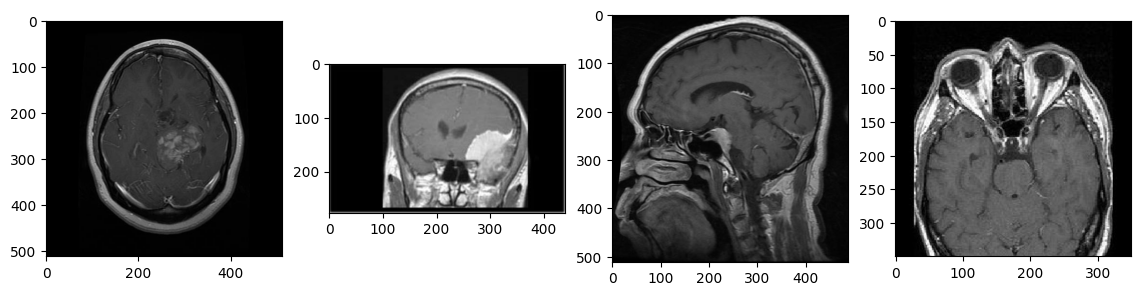

In [ ]:
labels = [
    'Category 1 Tumor',
    'Category 2 Tumor',
    'Category 3 Tumor',
    'No Tumor'
]

img=[load_img(train_path+'category1_tumor/gt_img (1).jpg'),
load_img(train_path+'category2_tumor/mt_img (1).jpg'),
load_img(train_path+'category3_tumor/pt_img (1).jpg'),
load_img(train_path+'no_tumor/nt_img (1).jpg')]
plt.figure(figsize=(14,14))
x, y = 1, 4
for i in range(4):
    plt.subplot(x, y, i+1)
    plt.imshow(img[i], cmap='gray')
    plt.title(labels[i])
plt.show()

In [ ]:
for i in range(4):
    x=img_to_array(img[i])
    print(x.shape)

(512, 512, 3)
(278, 440, 3)
(512, 488, 3)
(350, 350, 3)


Data Preprocessing and Augmentation:

In [ ]:
# how to define this value ? train_generator.batch_size ?
batch_size=16

In [ ]:
#Data Generation -Train-Test
train_datagen=ImageDataGenerator(rescale=1./255,
                                shear_range=0.3,
                                horizontal_flip=True,
                                zoom_range=0.3)

test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
        train_path,
        target_size=(224,224),
        batch_size=batch_size,
        class_mode="categorical",
        color_mode="rgb")

test_generator=test_datagen.flow_from_directory(
        test_path,
        target_size=(224,224),
        batch_size=batch_size,
        class_mode="categorical",
        color_mode="rgb")

Found 3224 images belonging to 4 classes.


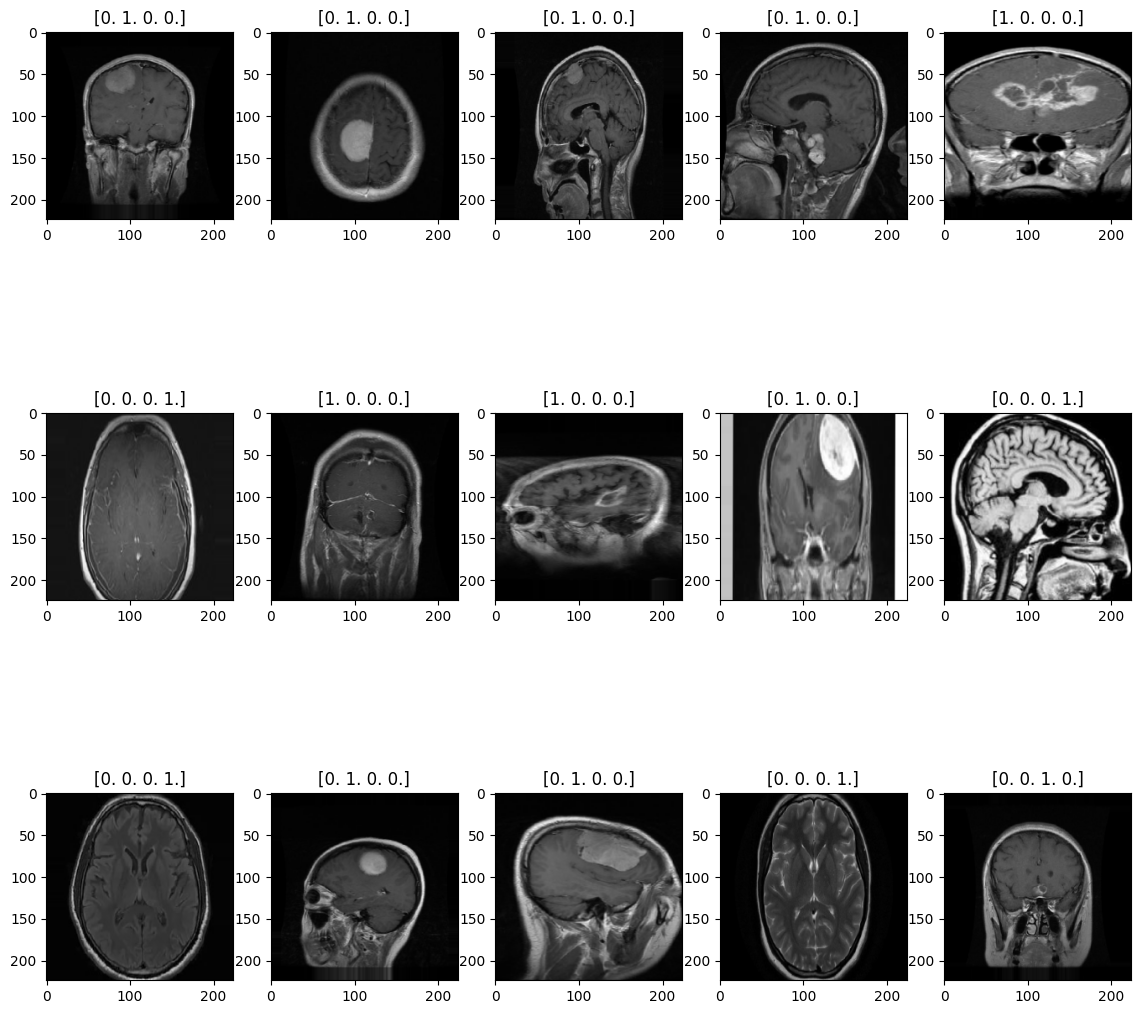

In [ ]:
batch_1_img = train_generator[0]
plt.figure(figsize=(14,14))
x, y = 3, 5
for i in range(15):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.subplot(x, y, i+1)
    plt.imshow(img)
    plt.title(lab)
plt.show()

# Building Model

The VGG16 model pre-trained on ImageNet, should remove its top layers, adds new classification layers, freeze the pre-trained layers, and create a new model for image classification.

In [ ]:
# Load the VGG16 model without the top classification layer
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224,224, 3))

# Freeze the pre-trained layers
for layer in vgg16.layers:
    layer.trainable = False

# Build classification layers on top of the VGG16 base
x = Flatten()(vgg16.output)
out = Dense(4, activation='softmax')(x)

# Ceating new model using the modified VGG16 base as the input and the newly added classification layers as the output.
model = Model(inputs=vgg16.input, outputs=out)

# summary of the model architecture
# layers, output shapes, the total number of parameters.
model.summary()

```
`include_top = False `
```
excluding the fully connected layers at the top of the network.
```
`weights='imagenet'`
```
specifies that you want to load the pre-trained weights that were learned during training on the ImageNet dataset.
```
for layer in vgg16.layers:
    layer.trainable = False
```
Iterates through all the layers in the VGG16 model and sets their trainable attribute to False. This effectively freezes the weights of the pre-trained layers so that they won't be updated during the training process. Only the newly added layers on top will be trained.
```
x = Flatten()(vgg16.output)
out = Dense(4, activation='softmax')(x)
```
Building the classification layers on top of the VGG16 base. The output from the last layer of the VGG16 model is flattened using the Flatten layer, which converts the 2D feature maps into a 1D vector.

Then, add a Dense layer with 4 units (classification problem with 4 classes) and a softmax activation function.

# Compilation of the model.

In [ ]:
# Compile the model
model.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])

Compiles the model, configuring its learning process before training.

After compiling the model and defining the callbacks, you can proceed to train the model using your training data and validation data with the fit() function. The callbacks you defined will be used during the training process to monitor the validation loss and potentially stop training early if the loss stagnates.

In [ ]:
callbacks=[EarlyStopping(monitor='val_loss',patience=10)]

Callbacks are functions that you can specify to be called at certain points during the training process. They are useful for performing actions like saving the best model, stopping training if a certain condition is met, etc.

In [ ]:
# steps_per_epoch = train_generator.samples // train_generator.batch_size
history = model.fit(
    train_generator,
    steps_per_epoch = 2581 // batch_size,
    epochs=10,
    callbacks=callbacks)

In [ ]:
# # Plot training history
# plt.plot(history.history['accuracy'])
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.show()

# Calculating loss and accuracy

In [ ]:
loss16, accuracy16 = model.evaluate(test_generator, steps=test_generator.samples // 128)
print("Test Loss:", loss16)
print("Test Accuracy:", accuracy16)

# Model Testing

In [ ]:
# Load and preprocess the input image
input_image_path = '/content/brain.jpg'
input_image = load_img(input_image_path, target_size=(224, 224))
input_image_array = img_to_array(input_image)
input_image_array = np.expand_dims(input_image_array, axis=0)
input_image_array = preprocess_input(input_image_array)

# Make predictions using the model
predictions = model.predict(input_image_array)
predicted_class = np.argmax(predictions[0])  # Get the index of the highest probability class

# Map the predicted index to the actual class name
class_names = train_generator.class_indices
predicted_class_name = [k for k, v in class_names.items() if v == predicted_class][0]

print("Predicted class:", predicted_class_name)


1/1 [==============================] - 0s 395ms/step
Predicted class: category2_tumor
